Formulation and solution of a standard $H_\infty$ mixed sensitivity problem of the form
$$\left\|\begin{array}{c} W_e S \\ W_u KS \end{array}\right\|_\infty \leq \gamma
$$
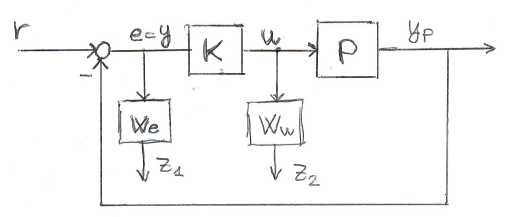

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import control as ct
import rpc_diism.robust as rb

Utility functions

In [2]:
def step_opposite(g, t):
    # Compute reponse to step of [1,-1] of a system with 2 inputs and 2 outputs
    _, yu1 = ct.step_response(g, t, input=0, squeeze=True)
    _, yu2 = ct.step_response(g, t, input=1, squeeze=True)
    return yu1 - yu2

Plant

In [3]:
s = ct.tf('s')
# Plant definition
den = [0.2, 1.2, 1]
P = ct.tf([[[1], [1]],
              [[2, 1], [2]]],
             [[den, den],
              [den, den]])
display("Plant transfer function", P)

# Convert to state space, so that feedback() doesn't complain
P = ct.ss(P)

'Plant transfer function'

TransferFunction(
[[array([1]), array([1])],
 [array([2, 1]), array([2])]],
[[array([0.2, 1.2, 1. ]), array([0.2, 1.2, 1. ])],
 [array([0.2, 1.2, 1. ]), array([0.2, 1.2, 1. ])]],
outputs=2, inputs=2)

Simulate open loop plant to input [1,-1]. Observe that outputs do not track inputs.

Text(0.5, 1.0, 'Open loop response to input [1,-1]')

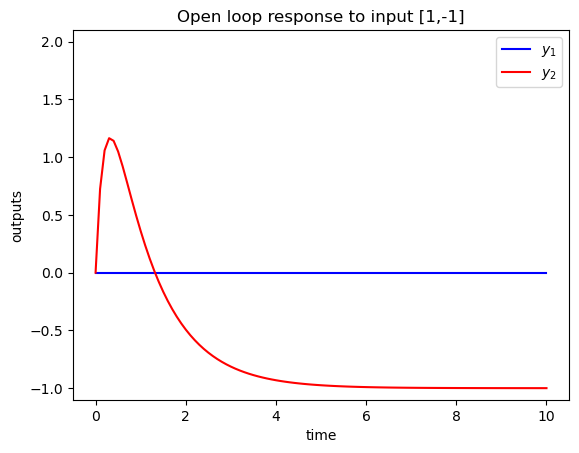

In [4]:
t = np.linspace(0, 10, 101)
y = step_opposite(P,t)
plt.plot(t, y[0], 'b', label='$y_1$' )
plt.plot(t, y[1], 'r', label='$y_2$')
plt.xlabel('time')
plt.ylabel('outputs')
plt.ylim([-1.1, 2.1])
plt.legend()
plt.title('Open loop response to input [1,-1]')

Perform two mixed sensitivity designs, 1 and 2. In design 2, the bandwidth of output $y_2$ is increased by moving the crossover frequency of the corresponding sensitivity weight two decades higher than in design 1.

In [5]:
# Design_1: equal weighting on each output
# Weight on S
M = 1.5
e = 1e-4
wb = 0.25 # Crossover frequency
We11_1 = ct.ss(rb.weightS(wb, M, e, 1))
We_1 = We11_1.append(We11_1) # Block diagonal combination of We11_1 with itself
# Weight on KS: identity
Wu_1 = ct.ss([], [], [],np.eye(2))
# Do the optimization and compute the achieved inf norm gamma
K_1, _, info = ct.mixsyn(P, We_1, Wu_1)
gamma_1 = info[0]

# Design_2: increase bandwidth of output 2 by moving crossover frequency 100 times higher
wb2_2 = 25 # Crossover frequency for output 2
We22_2 = ct.ss(rb.weightS(wb2_2, M, e, 1))
We_2 = We11_1.append(We22_2) # Block diagonal combination of We11_1 and We22_2

K_2, _, info = ct.mixsyn(P, We_2, Wu_1)
gamma_2 = info[0]

# Print the achieved H_inf norm of the combined sensitivity function
display('Design_1 gamma: {:.3g} '.format(gamma_1))
display('Design_2 gamma: {:.3g} '.format(gamma_2))


'Design_1 gamma: 2.8 '

'Design_2 gamma: 2.92 '

Closed-loop transfer functions

In [6]:
# Compute sensitivity for the two designs
I = ct.ss([], [], [], np.eye(2)) # Identity system
S_1 = ct.feedback(I,P*K_1)
S_2 = ct.feedback(I,P*K_2)
# Compute complementary sensitivity for the 2 designs
T_1 = (P*K_1).feedback(I)
T_2 = (P*K_2).feedback(I)
# Compute input sensitivity for the 2 designs
KS_1 = K_1*S_1
KS_2 = K_2*S_2

In [7]:
# Frequency range
w = np.logspace(-2, 2, 101)

Do singular value plot of the obtained closed loop sensitivities

Text(0.5, 1.0, 'Singular values of S_1 vs. gamma_1*inv(We_1)')

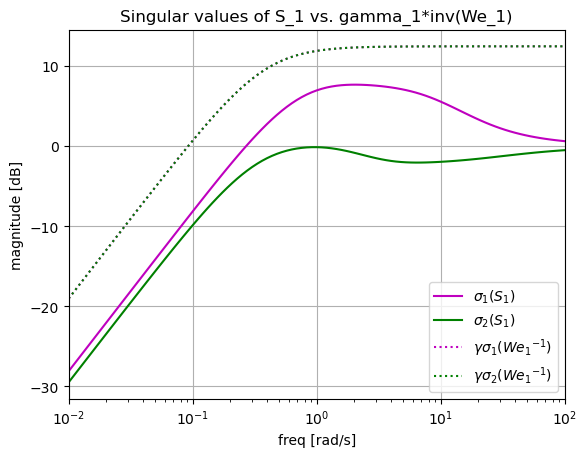

In [8]:
# Compute singular values of S over frequency
Ssv_1 = rb.sigma(S_1, w)
Ssv_2 = rb.sigma(S_2, w)

# We plot the singular values of gamma*invss(We) along with S to verify that ||We*S||_inf <= gamma
# (we do it only for design 1) 
Weinv_1 = rb.invss(We_1)
Weinvsv_1 = rb.sigma(Weinv_1, w) * gamma_1

plt.semilogx(w, 20*np.log10(Ssv_1[:, 0]), 'm', label=r'$\sigma_1(S_1)$')
plt.semilogx(w, 20*np.log10(Ssv_1[:, 1]), 'g', label=r'$\sigma_2(S_1)$')
plt.semilogx(w, 20*np.log10(Weinvsv_1[:, 0]), 'm:', label=r'$\gamma \sigma_1({We_1}^{-1})$')
plt.semilogx(w, 20*np.log10(Weinvsv_1[:, 1]), 'g:', label=r'$\gamma \sigma_2({We_1}^{-1})$')
plt.ylabel('magnitude [dB]')
plt.xlim([1e-2, 1e2])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of S_1 vs. gamma_1*inv(We_1)')


Text(0.5, 1.0, 'Singular values of S')

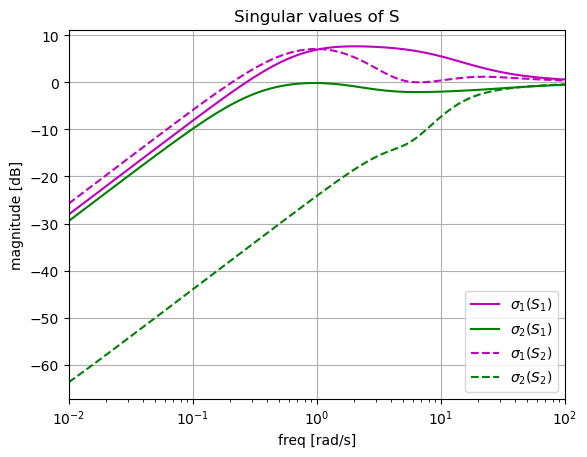

In [9]:
# Plot singular values of the sensitivity S for the 2 designs

plt.semilogx(w, 20*np.log10(Ssv_1[:, 0]), 'm', label=r'$\sigma_1(S_1)$')
plt.semilogx(w, 20*np.log10(Ssv_1[:, 1]), 'g', label=r'$\sigma_2(S_1)$')
plt.semilogx(w, 20*np.log10(Ssv_2[:, 0]), 'm--', label=r'$\sigma_1(S_2)$')
plt.semilogx(w, 20*np.log10(Ssv_2[:, 1]), 'g--', label=r'$\sigma_2(S_2)$')
plt.ylabel('magnitude [dB]')
plt.xlim([1e-2, 1e2])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of S')

Text(0.5, 1.0, 'Singular values of KS_1 vs. gamma_1*inv(Wu_1)')

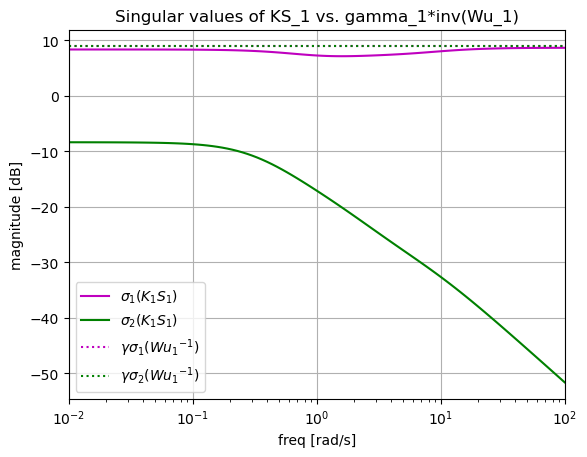

In [10]:
# Singular value plot of the input sensitivity KS_1 vs. gamma_1*inv(Wu_1)
Wuinv_1 = rb.invss(Wu_1)
Wuinvsv_1 = rb.sigma(Wuinv_1, w)*gamma_1

KSsv_1 = rb.sigma(KS_1, w)

plt.semilogx(w, 20*np.log10(KSsv_1[:, 0]), 'm', label=r'$\sigma_1(K_1 S_1)$')
plt.semilogx(w, 20*np.log10(KSsv_1[:, 1]), 'g', label=r'$\sigma_2(K_1 S_1)$')
plt.semilogx(w, 20*np.log10(Wuinvsv_1[:, 0]), 'm:', label=r'$\gamma \sigma_1({Wu_1}^{-1})$')
plt.semilogx(w, 20*np.log10(Wuinvsv_1[:, 1]), 'g:', label=r'$\gamma \sigma_2({Wu_1}^{-1})$')
plt.ylabel('magnitude [dB]')
plt.xlim([1e-2, 1e2])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of KS_1 vs. gamma_1*inv(Wu_1)')

Text(0.5, 1.0, 'Singular values of KS')

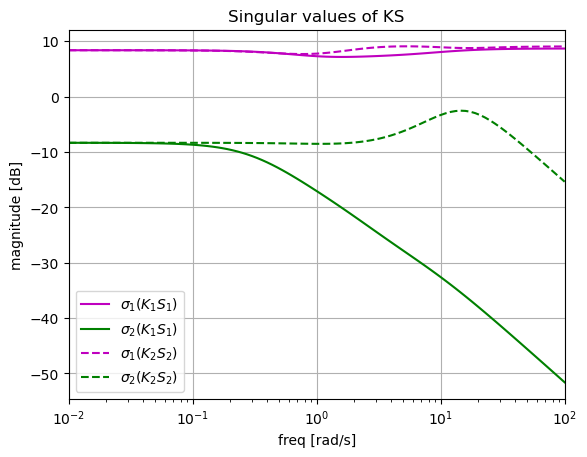

In [11]:
# Plot singular values of the input sensitivity for the 2 designs

KSsv_2 = rb.sigma(KS_2, w)

plt.semilogx(w, 20*np.log10(KSsv_1[:, 0]), 'm', label=r'$\sigma_1(K_1 S_1)$')
plt.semilogx(w, 20*np.log10(KSsv_1[:, 1]), 'g', label=r'$\sigma_2(K_1 S_1)$')
plt.semilogx(w, 20*np.log10(KSsv_2[:, 0]), 'm--', label=r'$\sigma_1(K_2 S_2)$')
plt.semilogx(w, 20*np.log10(KSsv_2[:, 1]), 'g--', label=r'$\sigma_2(K_2 S_2)$')
plt.ylabel('magnitude [dB]')
plt.xlim([1e-2, 1e2])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of KS')


Text(0.5, 1.0, 'Singular values of T')

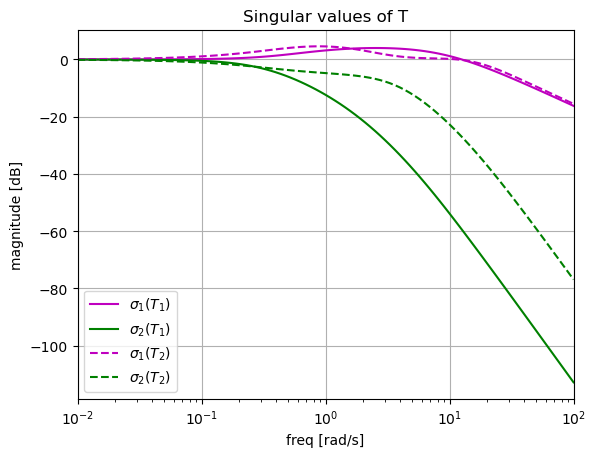

In [12]:
# Plot singular values of the complementary sensitivity for the 2 designs

Tsv_1 = rb.sigma(T_1, w)
Tsv_2 = rb.sigma(T_2, w)

plt.semilogx(w, 20*np.log10(Tsv_1[:, 0]), 'm', label=r'$\sigma_1(T_1)$')
plt.semilogx(w, 20*np.log10(Tsv_1[:, 1]), 'g', label=r'$\sigma_2(T_1)$')
plt.semilogx(w, 20*np.log10(Tsv_2[:, 0]), 'm--', label=r'$\sigma_1(T_2)$')
plt.semilogx(w, 20*np.log10(Tsv_2[:, 1]), 'g--', label=r'$\sigma_2(T_2)$')
plt.ylabel('magnitude [dB]')
plt.xlim([1e-2, 1e2])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of T')

Time response of closed loop. We plot the response to [1,-1] to separate the plots.
Observe that tracking of a constant reference is now ok. Furthermore, design 2 leads to faster response in $y_2$ because of increased bandwidth

Text(0.5, 1.0, 'Closed loop response to reference [1,-1]')

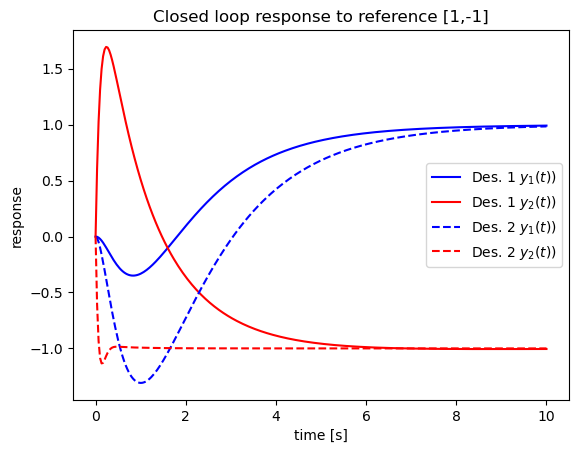

In [13]:
time = np.linspace(0, 10, 301)

y_1 = step_opposite(T_1, time)
y_2 = step_opposite(T_2, time)

plt.plot(time, y_1[0], 'b', label='Des. 1 $y_1(t))$')
plt.plot(time, y_1[1], 'r', label='Des. 1 $y_2(t))$')
plt.plot(time, y_2[0], 'b--', label='Des. 2 $y_1(t))$')
plt.plot(time, y_2[1], 'r--', label='Des. 2 $y_2(t))$')
plt.xlabel('time [s]')
plt.ylabel('response')
plt.legend()
plt.title('Closed loop response to reference [1,-1]')

By looking at the singular values of KS, it is expected that the command input signal in above designs will be very sensitive to high frequency disturbances (KS does not roll off at high frequencies). Let's simulate the response in the command input to a sinusoidal disturbance for design 1

Text(0.5, 1.0, 'Closed loop response in the command input to sinsusoidal disturbance for design 1')

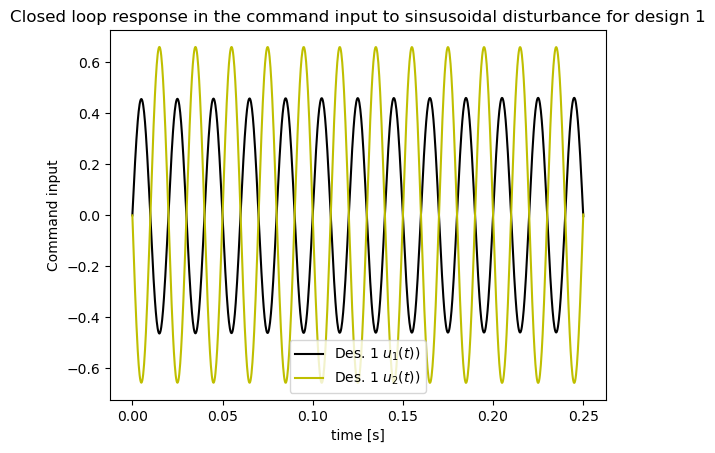

In [14]:
timen = np.linspace(0,0.25,1000).transpose() # Time vector for simulation
omeganoise = 2*np.pi*50 # Noise frequency
noise = [np.sin(omeganoise*timen), # Sinusoidal noise on both measurements
         np.sin(omeganoise*timen)]
timeval, u_1 = ct.forced_response(KS_1,timen,noise)

plt.plot(timeval, u_1[0], 'k', label='Des. 1 $u_1(t))$')
plt.plot(timeval, u_1[1], 'y', label='Des. 1 $u_2(t))$')
plt.xlabel('time [s]')
plt.ylabel('Command input')
plt.legend()
plt.title('Closed loop response in the command input to sinsusoidal disturbance for design 1')

Design 3. We want to modify the design 1 to make the command signal more insensitive to noise. We need to add a dynamic weight on KS to make it roll off at high frequency

In [15]:
# Weight on KS
Mu = 1.5
eu = 1e-4
wbc = 10 # We set the KS filter crossover frequency sufficiently lower than noise frequency
Wu11_3 = ct.ss(rb.weightU(wbc, Mu, eu, 1))
Wu_3 = Wu11_3.append(Wu11_3)
# Do the design again with the new KS weight
K_3, _, info = ct.mixsyn(P, We_1, Wu_3)
gamma_3 = info[0]

# Compute sensitivity for the new design
S_3 = ct.feedback(I,P*K_3)
# Compute input sensitivity for the new design
KS_3 = K_3*S_3

Let's check the singular value plots for the new design 3

Text(0.5, 1.0, 'Singular values of KS_3 vs. gamma_3*inv(Wu_3)')

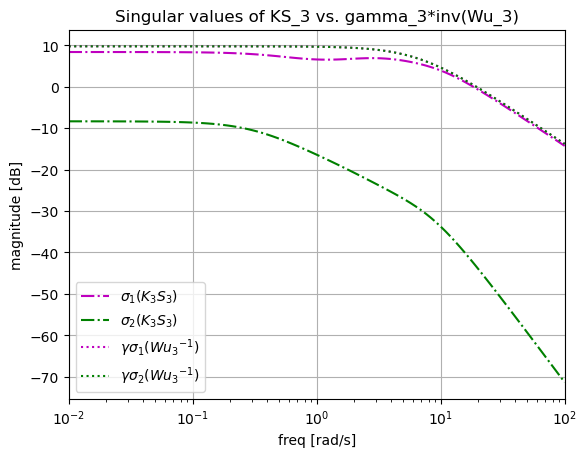

In [16]:
# Plot singular values of the input sensitivity for the new design

KSsv_3 = rb.sigma(KS_3, w)

Wuinv_3 = rb.invss(Wu_3)
Wuinvsv_3 = rb.sigma(Wuinv_3, w)*gamma_3

plt.semilogx(w, 20*np.log10(KSsv_3[:, 0]), 'm-.', label=r'$\sigma_1(K_3 S_3)$')
plt.semilogx(w, 20*np.log10(KSsv_3[:, 1]), 'g-.', label=r'$\sigma_2(K_3 S_3)$')
plt.semilogx(w, 20*np.log10(Wuinvsv_3[:, 0]), 'm:', label=r'$\gamma \sigma_1({Wu_3}^{-1})$')
plt.semilogx(w, 20*np.log10(Wuinvsv_3[:, 1]), 'g:', label=r'$\gamma \sigma_2({Wu_3}^{-1})$')
plt.ylabel('magnitude [dB]')
plt.xlim([1e-2, 1e2])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of KS_3 vs. gamma_3*inv(Wu_3)')

Now KS rolls off nicely at high frequency. Let's compare the responses in the command input to noise for designs 1 and 3.

Text(0.5, 1.0, 'Closed loop response in the command input to sinsusoidal disturbance. Design 1 vs. 3')

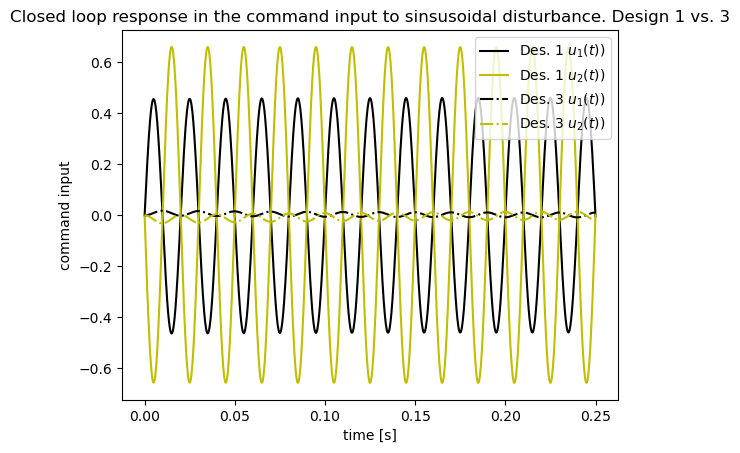

In [17]:
# Simulate the response in the command input to a sinusoidal disturbance for design 3
timeval, u_3 = ct.forced_response(KS_3,timen,noise)

plt.plot(timeval, u_1[0], 'k', label='Des. 1 $u_1(t))$')
plt.plot(timeval, u_1[1], 'y', label='Des. 1 $u_2(t))$')
plt.plot(timeval, u_3[0], 'k-.', label='Des. 3 $u_1(t))$')
plt.plot(timeval, u_3[1], 'y-.', label='Des. 3 $u_2(t))$')
plt.xlabel('time [s]')
plt.ylabel('command input')
plt.legend()
plt.title('Closed loop response in the command input to sinsusoidal disturbance. Design 1 vs. 3')

How does the sensitivity S get affected by the new requirement on input desensitization?

Text(0.5, 1.0, 'Singular values of S1 vs. S3')

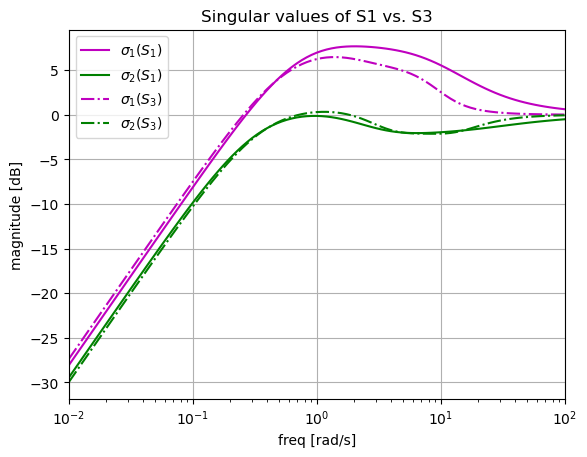

In [18]:
# Plot singular values of the sensitivity for the design1 vs. design 3

Ssv_3 = rb.sigma(S_3, w)

plt.semilogx(w, 20*np.log10(Ssv_1[:, 0]), 'm', label=r'$\sigma_1(S_1)$')
plt.semilogx(w, 20*np.log10(Ssv_1[:, 1]), 'g', label=r'$\sigma_2(S_1)$')
plt.semilogx(w, 20*np.log10(Ssv_3[:, 0]), 'm-.', label=r'$\sigma_1(S_3)$')
plt.semilogx(w, 20*np.log10(Ssv_3[:, 1]), 'g-.', label=r'$\sigma_2(S_3)$')
plt.ylabel('magnitude [dB]')
plt.xlim([1e-2, 1e2])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of S1 vs. S3')

And what about time response?

Text(0.5, 1.0, 'Closed loop response to reference [1,-1]. Design 1 vs. 3')

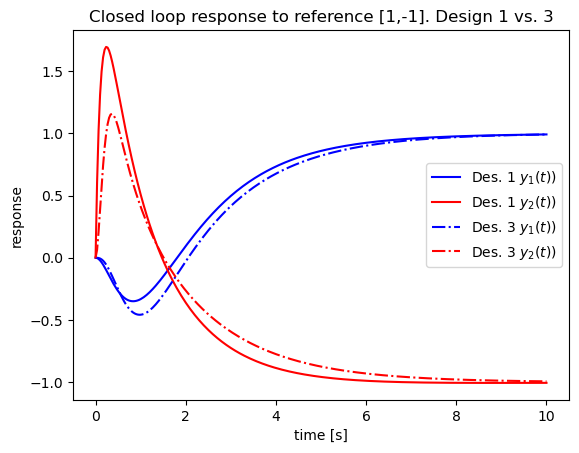

In [19]:
# Plot step response for design 3
T_3 = (P*K_3).feedback(I)
y_3 = step_opposite(T_3, time)

plt.plot(time, y_1[0], 'b', label='Des. 1 $y_1(t))$')
plt.plot(time, y_1[1], 'r', label='Des. 1 $y_2(t))$')
plt.plot(time, y_3[0], 'b-.', label='Des. 3 $y_1(t))$')
plt.plot(time, y_3[1], 'r-.', label='Des. 3 $y_2(t))$')
plt.xlabel('time [s]')
plt.ylabel('response')
plt.legend()
plt.title('Closed loop response to reference [1,-1]. Design 1 vs. 3')

Design 3 shows slower closed-loop response than design 1. Probably, lower controller gains at high frequency in design 3, required for input desensitization, have chewed up a little bandwidth!